# Pymaceuticals Inc.
---

### Analysis

No insights can be drawn regarding relative effectiveness of drugs sampled in this study for the following reasons:

* We have not used the control group (e.g. placebo regimen) to establish causality by isolating the effect of the independent variable (e.g. drug regimen) on the dependent variable (e.g. tumor volume in time).
    
* We have observed tumor volume for a given subset of drug regimens (e.g. Capomulin, Ramicane, Infubinol, Ceftamin). We have not observed the same outcomes for the rest of the regimens (e.g. Stelasyn, Zoniferol, Ketapril, Propriva, Naftisol). 
    
* We have observed tumor volume at final timepoints. We have not observed delta tumor volume over time.
    
* Several potential demographic sources of sampling bias have not been examined:

    * Specimen size. We know from our analysis that tumors grow larger in larger mice. We don't know how final tumor sizes in a given regimen cohort may be biased by the weight of members in the cohort.

    * Sex / age. Similarly, we have not examined correlations between tumor size and specimen sex or age.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

study_data_complete = pd.merge(
    mouse_metadata, study_results, how="inner", on=["Mouse ID", "Mouse ID"]
)
# Display the data table for preview
study_data_complete.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
# Checking the number of mice.
len(study_data_complete["Mouse ID"].unique())

249

In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint.
groupby_ID_Time = study_data_complete.groupby(["Mouse ID", "Timepoint"]).count()
groupby_ID_Time.loc[groupby_ID_Time["Drug Regimen"] > 1]

Drug Regimen  Sex  Age_months  Weight (g)  \
Mouse ID Timepoint                                              
g989     0                     2    2           2           2   
         5                     2    2           2           2   
         10                    2    2           2           2   
         15                    2    2           2           2   
         20                    2    2           2           2   

                    Tumor Volume (mm3)  Metastatic Sites  
Mouse ID Timepoint                                        
g989     0                           2                 2  
         5                           2                 2  
         10                          2                 2  
         15                          2                 2  
         20                          2                 2

In [4]:
# Optional: Get all the data for the duplicate mouse ID.

In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
clean_df = study_data_complete.drop(
    study_data_complete[study_data_complete["Mouse ID"] == "g989"].index
)
clean_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [6]:
# Checking the number of mice in the clean DataFrame.
len(clean_df["Mouse ID"].unique())

248

## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

gb_RV = clean_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"]

sumstats_gbRV = pd.DataFrame({
        "Mean Tumor Volume": gb_RV.mean(),
        "Median Tumor Volume": gb_RV.median(),
        "Tumor Volume Variance": gb_RV.var(),
        "Tumor Volume Std. Dev.": gb_RV.std(),
        "Tumor Volume Std. Err.": gb_RV.sem()})

sumstats_gbRV

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
# Using the aggregation method, produce the same summary statistics in a single line.
gb_RV.agg(["mean", "median", "var", "std", "sem"]).style.set_caption(
    "Tumor Volume (mm3)").set_table_styles(
    [{
            "selector": "caption",
            "props": [
                ("color", "black"),
                ("font-size", "12px"),
                ("text-align", "right"),
                ("font-weight", "bold"),
            ],
        }
    ]
)

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

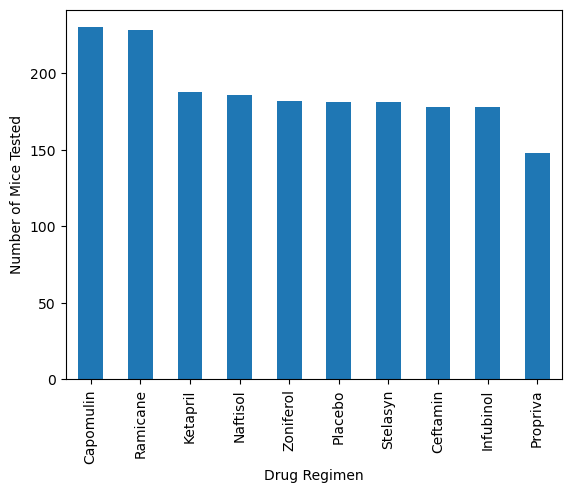

In [9]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
pandas_bar = (
    clean_df.groupby("Drug Regimen")
    .count()["Mouse ID"].sort_values(ascending=False)
    .plot(kind="bar", legend=False)
)
pandas_bar.set_ylabel("Number of Mice Tested");

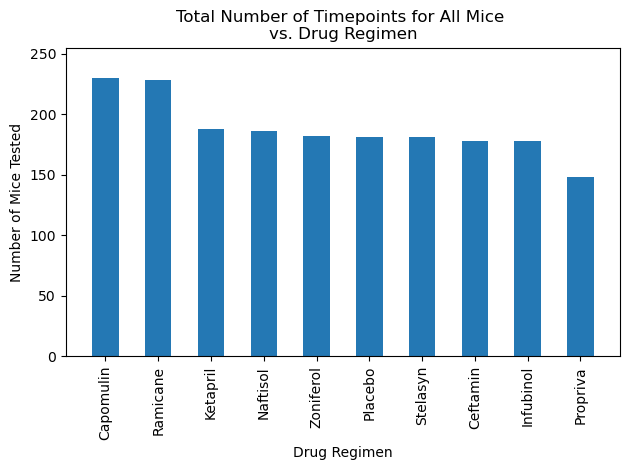

In [10]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
xy_values = clean_df.groupby("Drug Regimen").count()["Mouse ID"].sort_values(ascending=False)
x_values = xy_values.index
y_values = list(xy_values)
plt.bar(x_values, y_values, width=0.5, color="#2478B4", alpha=1, align="center")
plt.xticks(rotation=90)
plt.title("Total Number of Timepoints for All Mice \nvs. Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Mice Tested")
plt.xlim(-0.75, len(x_values) - 0.25)
plt.ylim(0, max(y_values) + 25)
plt.tight_layout()

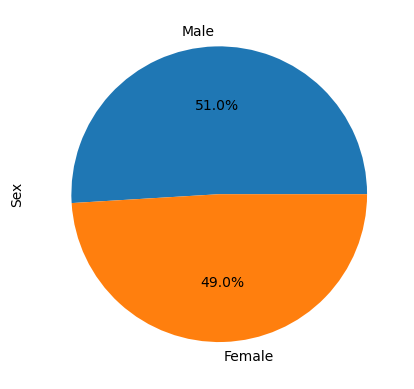

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
clean_df["Sex"].value_counts().plot(kind="pie", autopct="%1.1f%%");

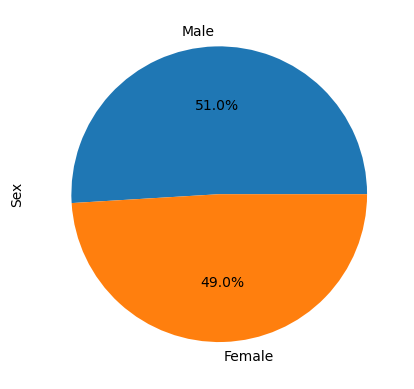

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(
    list(clean_df["Sex"].value_counts()),
    labels=["Male", "Female"],
    autopct="%1.1f%%",
)
plt.ylabel("Sex");

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:
# Capomulin, Ramicane, Infubinol, and Ceftamin
treatments = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Start by getting the last (greatest) timepoint for each mouse
gb_maxtime = clean_df.groupby(["Mouse ID"])["Timepoint"].max()

# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
last_vol_all_regimens = pd.merge(
    gb_maxtime,
    clean_df,
    how="left",
    on=["Mouse ID", "Timepoint"],
)


fin_vol_df = last_vol_all_regimens[
    last_vol_all_regimens["Drug Regimen"].isin(treatments)][
    ["Drug Regimen", "Tumor Volume (mm3)"]]

# fin_vol_df

gb_maxtime

Mouse ID
a203    45
a251    45
a262    45
a275    45
a366    30
        ..
z435    10
z578    45
z581    45
z795    45
z969    45
Name: Timepoint, Length: 248, dtype: int64

In [14]:
# Finding outliers without the benefit of a .describe() table

drugs_of_interest = {
    "Capomulin": None,
    "Ramicane": None,
    "Infubinol": None,
    "Ceftamin": None,
}

for drug in drugs_of_interest:
    drug_vols = fin_vol_df[fin_vol_df["Drug Regimen"] == drug]["Tumor Volume (mm3)"]
    quantiles = drug_vols.quantile([0.25, 0.75])

    lower_q = quantiles[0.25]
    upper_q = quantiles[0.75]
    iqr = upper_q - lower_q
    lower_bound = lower_q - 1.5 * iqr
    upper_bound = upper_q + 1.5 * iqr

    outlier_lo_filter = drug_vols < lower_bound
    outlier_hi_filter = drug_vols > upper_bound

    outlier_df = drug_vols[outlier_lo_filter | outlier_hi_filter]
    drugs_of_interest[drug] = outlier_df#.tolist()

drugs_of_interest

{'Capomulin': Series([], Name: Tumor Volume (mm3), dtype: float64),
 'Ramicane': Series([], Name: Tumor Volume (mm3), dtype: float64),
 'Infubinol': 31    36.321346
 Name: Tumor Volume (mm3), dtype: float64,
 'Ceftamin': Series([], Name: Tumor Volume (mm3), dtype: float64)}

In [15]:
# Find outliers with .describe()

describe_df = fin_vol_df.groupby("Drug Regimen").describe()[
    [("Tumor Volume (mm3)", "25%"), ("Tumor Volume (mm3)", "75%")]]

describe_df[("Tumor Volume (mm3)", "IQR")] = (describe_df[(
    "Tumor Volume (mm3)", "75%")] - describe_df[("Tumor Volume (mm3)", "25%")])
describe_df[("Tumor Volume (mm3)", "Lower Bound")] = (describe_df[(
    "Tumor Volume (mm3)", "25%")] - (describe_df[("Tumor Volume (mm3)", "IQR")] * 1.5))
describe_df[("Tumor Volume (mm3)", "Upper Bound")] = (describe_df[(
    "Tumor Volume (mm3)", "75%")] + (describe_df[("Tumor Volume (mm3)", "IQR")] * 1.5))

all_outliers = []
for drug in treatments:
    outliers = fin_vol_df.loc[(
        (fin_vol_df["Drug Regimen"] == drug) & (fin_vol_df["Tumor Volume (mm3)"] < describe_df.loc[drug, ("Tumor Volume (mm3)", "Lower Bound")]) |
        (fin_vol_df["Drug Regimen"] == drug) & (fin_vol_df["Tumor Volume (mm3)"]
                                                > describe_df.loc[drug, ("Tumor Volume (mm3)", "Upper Bound")])
    )]["Tumor Volume (mm3)"].tolist()
    if not outliers:
        all_outliers.append(drug + " has no potential outliers.")
    else:
        all_outliers.append(drug + "'s potential outliers: " +
                            ", ".join(map(str, outliers)))

print(describe_df)
print()
print(*all_outliers, sep="\n")

             Tumor Volume (mm3)                                              
                            25%        75%        IQR Lower Bound Upper Bound
Drug Regimen                                                                 
Capomulin             32.377357  40.159220   7.781863   20.704562   51.832015
Ceftamin              48.722078  64.299830  15.577752   25.355450   87.666458
Infubinol             54.048608  65.525743  11.477135   36.832905   82.741446
Ramicane              31.560470  40.659006   9.098537   17.912664   54.306811

Capomulin has no potential outliers.
Ramicane has no potential outliers.
Infubinol's potential outliers: 36.3213458
Ceftamin has no potential outliers.


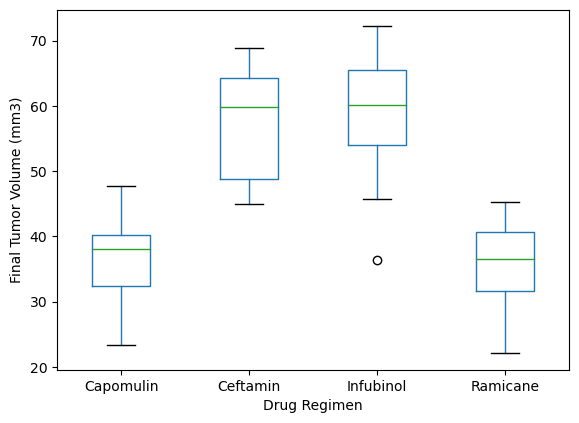

In [16]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.
boxplot = fin_vol_df.boxplot(
    column="Tumor Volume (mm3)", by="Drug Regimen", grid=False)
boxplot.set_ylabel("Final Tumor Volume (mm3)")
boxplot.set_xlabel("Drug Regimen")
plt.title("")
plt.suptitle("")
boxplot;

In [17]:
# A second method for generating the boxplot, using pyplot instead of pandas

# boxplot = plt.figure()
# axes1 = boxplot.add_subplot(1,1,1)
# axes1.boxplot(x=[
#     vol_per_regimen.loc[vol_per_regimen["Drug Regimen"]=="Capomulin","Tumor Volume (mm3)"],
#     vol_per_regimen.loc[vol_per_regimen["Drug Regimen"]=="Ramicane","Tumor Volume (mm3)"],
#     vol_per_regimen.loc[vol_per_regimen["Drug Regimen"]=="Infubinol","Tumor Volume (mm3)"],
#     vol_per_regimen.loc[vol_per_regimen["Drug Regimen"]=="Ceftamin","Tumor Volume (mm3)"],
# ],
#               labels=["Capomulin", "Ramicane", "Infubinol", "Ceftamin"],)

## Line and Scatter Plots

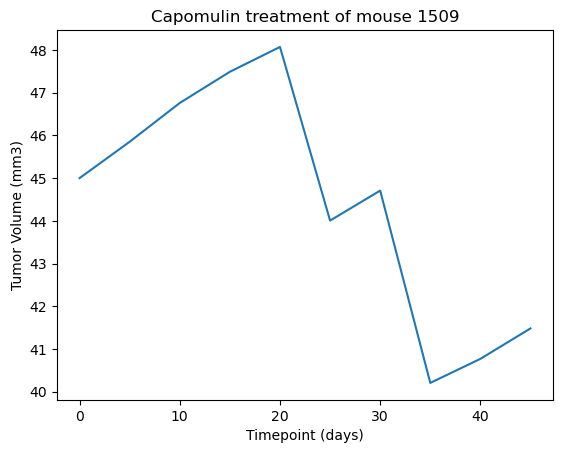

In [18]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
plot_onemouse = clean_df.loc[clean_df["Mouse ID"] == "l509"][
    ["Timepoint", "Tumor Volume (mm3)"]].plot("Timepoint", legend=False, title="Capomulin treatment of mouse 1509")
plot_onemouse.set_xlabel("Timepoint (days)")
plot_onemouse.set_ylabel("Tumor Volume (mm3)")
plot_onemouse;

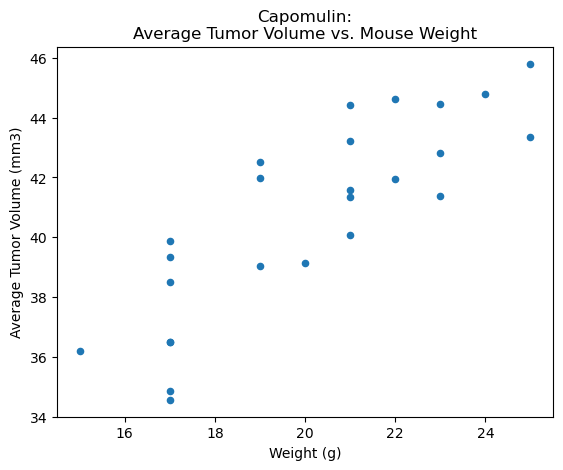

In [19]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
cap_df = (
    clean_df.loc[clean_df["Drug Regimen"] == "Capomulin"][
        ["Mouse ID","Weight (g)", "Tumor Volume (mm3)"]]
    .groupby(["Mouse ID"])
    .mean()
    .reset_index()
    .rename(columns={"Tumor Volume (mm3)": "Average Tumor Volume (mm3)"})
)

cap_df.plot.scatter(
    "Weight (g)",
    "Average Tumor Volume (mm3)",
    title="Capomulin:\nAverage Tumor Volume vs. Mouse Weight",
);

## Correlation and Regression

The correlation between mouse weight and the avg tumor volume is 0.84


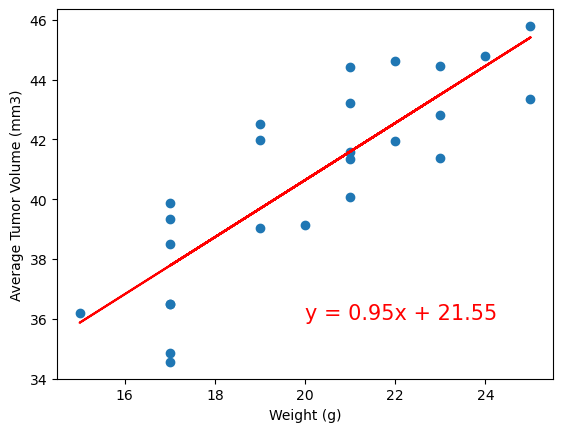

In [20]:
weightvol_df = clean_df.loc[clean_df["Drug Regimen"] == "Capomulin"][["Mouse ID","Weight (g)", "Tumor Volume (mm3)"]].groupby(["Mouse ID"]).mean()

x_values = weightvol_df["Weight (g)"]
y_values = weightvol_df["Tumor Volume (mm3)"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
print(f"The correlation between mouse weight and the avg tumor volume is {round(st.pearsonr(x_values,y_values)[0],2)}")
plt.show()

The correlation between mouse weight and the avg tumor volume is 0.84.


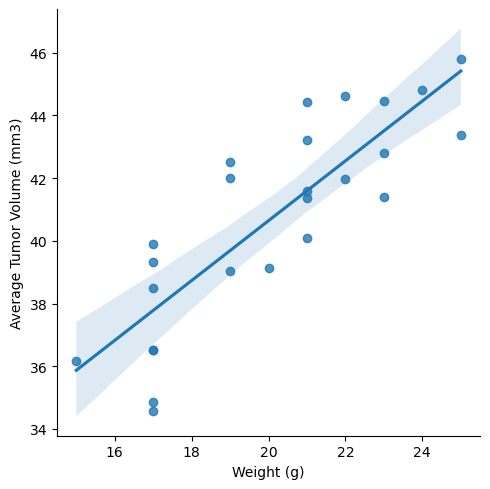

In [21]:
# Using seaborn for regression
import seaborn as sns

sns.lmplot(x="Weight (g)", y="Average Tumor Volume (mm3)", data=cap_df, fit_reg=True)
print(
    f"The correlation between mouse weight and the avg tumor volume is {round(cap_df.corr().iloc[0,1],2)}."
)